In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import time
from tqdm import tqdm
import scripts.theodolite_utils as ttfu
import scripts.resection_functions as rf
from scipy import stats

def R_z(theta):
    R = np.eye(4,4)
    R[0,:2] = [np.cos(theta), -np.sin(theta)]
    R[1,:2] = [np.sin(theta), np.cos(theta)]
    return R

def T_z(theta, t):
    T = R_z(theta)
    T[:3,3] = t
    return T
    
def dist(p,q):
    return np.linalg.norm(p[0:3]-q[0:3])

def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth12)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth13)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth23)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def cost_fun_ls(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)

    N = len(p1s_l)
    c = np.zeros((N*3))
    c[:N] = [(dist(p1,T12@p2)-d_truth12) for p1,p2 in zip(p1s_l, p2s_l)]
    c[N:2*N] = [(dist(p1,T13@p3)-d_truth13) for p1,p3 in zip(p1s_l, p3s_l)]
    c[2*N:] = [(dist(T12@p2,T13@p3)-d_truth23) for p2,p3 in zip(p2s_l, p3s_l)]
    return c/(3*N)

def cost_fun_ls_4dof(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T_4dof(xi_12)
    T13 = exp_T_4dof(xi_13)
    
    N = len(p1s_l)
    c = np.zeros((N*3))
    c[:N] = [(dist(p1,T12@p2)-d_truth12) for p1,p2 in zip(p1s_l, p2s_l)]
    c[N:2*N] = [(dist(p1,T13@p3)-d_truth13) for p1,p3 in zip(p1s_l, p3s_l)]
    c[2*N:] = [(dist(T12@p2,T13@p3)-d_truth23) for p2,p3 in zip(p2s_l, p3s_l)]
    return c/(3*N)

def vee(xi):    ## TODO: use LibLie wedge
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T

def vee_4dof(xi):    ## TODO: use LibLie wedge
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[0], 0],
                        [ xi[0], 0,     0],
                        [0, 0, 0]])
    T[:3,3] = xi[1:]
    return T

def exp_T_4dof(xi):   ## TODO: use LibLie
    return scipy.linalg.expm(vee_4dof(xi))
    
def exp_T(xi):   ## TODO: use LibLie
    return scipy.linalg.expm(vee(xi))

def exp_inv_T(A):   ## TODO: use LibLie
    return scipy.linalg.logm(A)

def result_new_resection_prior_only(Inter_distance, file_name_path, path_type, path_file_type):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k in zip(Inter_distance, file_name_path):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            T_1 = np.identity(4)
            
            p1t = T_1@p1.T
            p2t = T12_init@p2.T
            p3t = T13_init@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_new_resection_4dof(Inter_distance, file_name_path, path_type, path_file_type, save_tf, save_tf_file):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k,sf in zip(Inter_distance, file_name_path, save_tf_file):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            #T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            #T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            #T12_init_log = exp_inv_T(T12_init)
            #T13_init_log = exp_inv_T(T13_init)
            #x_init = [T12_init_log[2,1],T12_init_log[0,2],T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
            #          T13_init_log[2,1],T13_init_log[0,2],T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]
            x_init = [0,0,0,0,0,0,0,0]
            start_time = time.time()
            res = scipy.optimize.least_squares(lambda x: cost_fun_ls_4dof(p1, p2, p3, x[:4], x[4:], i[0], i[1], 
                                   i[2]), x0=x_init, method='lm', 
                                   ftol=1e-15, xtol=1e-15, x_scale=1.0, loss='linear', 
                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})
            
            
            stop_time = time.time()
            
            print(stop_time - start_time)
            print(res.fun/len(p1))
            xi_12 = res.x[:4]
            xi_13 = res.x[4:] 
            T12 = exp_T_4dof(xi_12)
            T13 = exp_T_4dof(xi_13)
            T_1 = np.identity(4)
            
            if(save_tf):
                ttfu.save_tf(T_1, T12, T13, sf+"tf-"+path_file_type+".csv")
            
            p1t = T_1@p1.T
            p2t = T12@p2.T
            p3t = T13@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_new_resection(Inter_distance, file_name_path, path_type, path_file_type, save_tf, save_tf_file):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k,sf in zip(Inter_distance, file_name_path, save_tf_file):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            T12_init_log = exp_inv_T(T12_init)
            T13_init_log = exp_inv_T(T13_init)
            x_init = [T12_init_log[2,1],T12_init_log[0,2],T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
                      T13_init_log[2,1],T13_init_log[0,2],T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]
            
            #f = lambda x: cost_fun_ls(p1, p2, p3, x[:6], x[6:], i[0], i[1], i[2])

            start_time = time.time()
            res = scipy.optimize.least_squares(lambda x: cost_fun_ls(p1, p2, p3, x[:6], x[6:], i[0], i[1], 
                                   i[2]), x0=x_init, method='lm', 
                                   ftol=1e-15, xtol=1e-15, x_scale=1.0, loss='linear', 
                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})
            
            
            stop_time = time.time()
            
            print(stop_time - start_time)
            print(res.fun/len(p1))
            xi_12 = res.x[:6]
            xi_13 = res.x[6:] 
            T12 = exp_T(xi_12)
            T13 = exp_T(xi_13)
            T_1 = np.identity(4)
            
            if(save_tf):
                ttfu.save_tf(T_1, T12, T13, sf+"tf-"+path_file_type+".csv")
            
            p1t = T_1@p1.T
            p2t = T12@p2.T
            p3t = T13@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_basic_resection(Inter_distance, file_name_marker, file_name_path, path_type, path_file_type):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,j,k in zip(Inter_distance, file_name_marker, file_name_path):
        m1, m2, m3, T_1, T_2, T_3 = tfu.read_marker_file(j, 1, 1)
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            p1t = T_1@p1.T
            p2t = T_2@p2.T
            p3t = T_3@p3.T

            timestamp = trimble_1[:,0]
            dist_prism_file = []
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Python older than 3.7 detected. 


In [2]:
# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

# 27 04 2022
Dist_prism_12_270422 = 0.8856608085851714
Dist_prism_13_270422 = 0.8264452483880412
Dist_prism_23_270422 = 1.0384219210289538
Dist_GPS_12_270422 = 0.7809547832390561
Dist_GPS_13_270422 = 0.8259590286006459
Dist_GPS_23_270422 = 0.5191274645630007  

# 27 04 2022 soir
Dist_prism_12_270422_soir = 0.8868846942534616
Dist_prism_13_270422_soir = 0.829169129877633
Dist_prism_23_270422_soir = 1.0387571594276301
Dist_GPS_12_270422_soir = 0.7837749633840095
Dist_GPS_13_270422_soir = 0.8323125081688734
Dist_GPS_23_270422_soir = 0.5187055120945835

# 05 05 2022
Dist_prism_12_050522 = 0.3819811991689936
Dist_prism_13_050522 = 0.4426382054042266
Dist_prism_23_050522 = 0.2564685508415531

# 13 05 2022
Dist_prism_12_130522 = 0.8113569618671205
Dist_prism_13_130522 = 0.8695313906832193
Dist_prism_23_130522 = 1.0383292631343506
Dist_GPS_12_130522 = 0.7800801192552722
Dist_GPS_13_130522 = 0.8396027021467387
Dist_GPS_23_130522 = 0.5157656903777014

# 23 05 2022
Dist_prism_12_230522 = 0.3851913749758221
Dist_prism_13_230522 = 0.4433899497583272
Dist_prism_23_230522 = 0.25861327466684897

Inter_distance = [[Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                 [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                 [Dist_prism_12_120322,Dist_prism_13_120322,Dist_prism_23_120322,Dist_GPS_12_120322,Dist_GPS_13_120322,Dist_GPS_23_120322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                 [Dist_prism_12_270422,Dist_prism_13_270422,Dist_prism_23_270422,Dist_GPS_12_270422,Dist_GPS_13_270422,Dist_GPS_23_270422],
                 [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                 [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522]]


file_name_path = ['./data/prediction/TS/20220224/',
                      './data/prediction/TS/20220307/',
                     './data/prediction/TS/20220312/',
                     './data/prediction/TS/20220314/',
                     './data/prediction/TS/20220316/',
                     './data/prediction/TS/20220331-1/',
                     './data/prediction/TS/20220331-2/',
                     './data/prediction/TS/20220427/',
                     './data/prediction/TS/20220505_cones/',
                     './data/prediction/TS/20220505_empty/']

file_name_marker = ['./data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
             './data/total_station/20220307/theodolite_reference_prisms.txt',
             './data/total_station/20220312/theodolite_reference_prisms.txt',
             './data/total_station/20220314/theodolite_reference_prisms.txt',
             './data/total_station/20220316/theodolite_reference_prisms.txt',
             './data/total_station/20220331-1/theodolite_reference_prisms.txt',
             './data/total_station/20220331-2/theodolite_reference_prisms.txt',
             './data/total_station/20220427/theodolite_reference_prisms.txt',
             './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
             './data/total_station/20220505_cones/theodolite_reference_prisms.txt']

'''
Inter_distance = [[Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522]]

file_name_path = ['./data/prediction/TS/20220505_empty/']

file_name_marker = ['./data/total_station/20220505_cones/theodolite_reference_prisms.txt']
'''


"\nInter_distance = [[Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522]]\n\nfile_name_path = ['./data/prediction/TS/20220505_empty/']\n\nfile_name_marker = ['./data/total_station/20220505_cones/theodolite_reference_prisms.txt']\n"

In [ ]:
ttfu = importlib.reload(ttfu)

result = []

path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-L_'
dist_prism_raw, dist_prism_raw_all, dist_prism_file_list = result_basic_resection(Inter_distance, file_name_marker, file_name_path, path_type, path_file_type)
result.append(dist_prism_raw_all)

path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-L_'
dist_prism_filtered, dist_prism_filtered_all, dist_prism_file_list = result_new_resection(Inter_distance, file_name_path, path_type, path_file_type)
result.append(dist_prism_filtered_all)
    
path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-SGP-1000_'
dist_prism_raw, dist_prism_raw_all, dist_prism_file_list = result_basic_resection(Inter_distance, file_name_marker, file_name_path, path_type, path_file_type)
result.append(dist_prism_raw_all)

path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-SGP-1000_'
dist_prism_filtered, dist_prism_filtered_all, dist_prism_file_list = result_new_resection(Inter_distance, file_name_path, path_type, path_file_type)
result.append(dist_prism_filtered_all)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(14, 6))
ax = fig.add_subplot(111)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4], ["Basic L \n\n Median: "+str(round(np.median(result[0]),2))+"mm \n Std: "+str(round(np.std(result[0]),2))+"mm",
                          "New L \n\n Median: "+str(round(np.median(result[1]),2))+"mm \n Std: "+str(round(np.std(result[1]),2))+"mm",
                          "Basic SGP \n\n Median: "+str(round(np.median(result[2]),2))+"mm \n Std: "+str(round(np.std(result[2]),2))+"mm",
                          "New SGP \n\n Median: "+str(round(np.median(result[3]),2))+"mm \n Std: "+str(round(np.std(result[3]),2))+"mm"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.savefig("./figs/comparison_method-f-2-1-1-1-6-1-n.jpg")

In [ ]:
ttfu = importlib.reload(ttfu)

result_basic = []

path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-L_'
dist_prism_raw_basic, dist_prism_raw_all_basic, dist_prism_file_list_basic = result_basic_resection(Inter_distance, file_name_marker, file_name_path, path_type, path_file_type)
result_basic.append(dist_prism_raw_all_basic)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot(dist_prism_file_list_basic, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ["1 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[0]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[0]),2))+"mm",
                          "2 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[1]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[1]),2))+"mm",
                          "3 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[2]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[2]),2))+"mm",
                          "4 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[3]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[3]),2))+"mm",
                          "5 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[4]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[4]),2))+"mm",
                          "6 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[5]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[5]),2))+"mm",
                          "7 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[6]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[6]),2))+"mm",
                          "8 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[7]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[7]),2))+"mm",
                          "9 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[8]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[8]),2))+"mm",
                          "10 \n\n Median: "+str(round(np.median(dist_prism_file_list_basic[9]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_basic[9]),2))+"mm"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
#fig.savefig("./figs/basic_resection_datasets-f-2-1-1-1-6-1-L.jpg")

In [ ]:
ttfu = importlib.reload(ttfu)

result_new = []
path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-L_'
dist_prism_filtered_new, dist_prism_filtered_all_new, dist_prism_file_list_new = result_new_resection(Inter_distance, file_name_path, path_type, path_file_type, True, file_name_path)
result_new.append(dist_prism_filtered_all_new)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot(dist_prism_file_list_new, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ["1 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[0]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[0]),2))+"mm",
                          "2 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[1]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[1]),2))+"mm",
                          "3 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[2]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[2]),2))+"mm",
                          "4 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[3]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[3]),2))+"mm",
                          "5 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[4]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[4]),2))+"mm",
                          "6 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[5]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[5]),2))+"mm",
                          "7 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[6]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[6]),2))+"mm",
                          "8 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[7]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[7]),2))+"mm",
                          "9 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[8]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[8]),2))+"mm",
                          "10 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[9]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[9]),2))+"mm"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
#fig.savefig("./figs/new_resection_datasets-f-2-1-1-1-6-1-L.jpg")

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(15, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(dist_prism_file_list_basic,dist_prism_file_list_new):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(np.std(result[0]),2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(np.std(result[1]),2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(np.std(result[2]),2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(np.std(result[3]),2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(np.std(result[4]),2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(np.std(result[5]),2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(np.std(result[6]),2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(np.std(result[7]),2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(np.std(result[8]),2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(np.std(result[9]),2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(np.std(result[10]),2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(np.std(result[11]),2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(np.std(result[12]),2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(np.std(result[13]),2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(np.std(result[14]),2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(np.std(result[15]),2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(np.std(result[16]),2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(np.std(result[17]),2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(np.std(result[18]),2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(np.std(result[19]),2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/comparison_resection_datasets_dogbox-f-2-1-1-1-6-1-n.jpg")


In [ ]:
ttfu = importlib.reload(ttfu)

result_new = []
path_type = 'filtered/'
path_file_type = 'f-2-1-1-1-6-1-L_'
dist_prism_filtered_new, dist_prism_filtered_all_new, dist_prism_file_list_new = result_new_resection_prior_only(Inter_distance, file_name_path, path_type, path_file_type)
result_new.append(dist_prism_filtered_all_new)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot(dist_prism_file_list_new, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ["1 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[0]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[0]),2))+"mm",
                          "2 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[1]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[1]),2))+"mm",
                          "3 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[2]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[2]),2))+"mm",
                          "4 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[3]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[3]),2))+"mm",
                          "5 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[4]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[4]),2))+"mm",
                          "6 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[5]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[5]),2))+"mm",
                          "7 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[6]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[6]),2))+"mm",
                          "8 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[7]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[7]),2))+"mm",
                          "9 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[8]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[8]),2))+"mm",
                          "10 \n\n Median: "+str(round(np.median(dist_prism_file_list_new[9]),2))+"mm \n Std: "+str(round(np.std(dist_prism_file_list_new[9]),2))+"mm"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.savefig("./figs/new_resection_datasets_prior_only-f-2-1-1-1-6-1-L.jpg")

In [ ]:
def metric_error_resection(file_name_path_marker, tf_file_new_resection, path_file_type):
    error_basic_all = []
    error_new_all = []
    
    for i_f,k_f in zip(file_name_path_marker, tf_file_new_resection):
        error_basic = []
        error_new = []
        marker_1, marker_2, marker_3, T1_basic, T12_basic, T13_basic = ttfu.read_marker_file(i_f, 1, 1)
        
        Tf = ttfu.read_saved_tf(k_f+path_file_type)
        
        p1_basic = T1_basic@marker_1
        p2_basic = T12_basic@marker_2
        p3_basic = T13_basic@marker_3
        
       
        p1_new = Tf[0]@marker_1
        p2_new = Tf[1]@marker_2
        p3_new = Tf[2]@marker_3
        
        for i,j,k in zip(p1_basic.T, p2_basic.T, p3_basic.T):
            dist_12 = np.linalg.norm(i[0:3]-j[0:3])*1000
            dist_13 = np.linalg.norm(i[0:3]-k[0:3])*1000
            dist_23 = np.linalg.norm(k[0:3]-j[0:3])*1000
            error_basic.append(dist_12)
            error_basic.append(dist_13)
            error_basic.append(dist_23)
            
        for i,j,k in zip(p1_new.T, p2_new.T, p3_new.T):
            dist_12 = np.linalg.norm(i[0:3]-j[0:3])*1000
            dist_13 = np.linalg.norm(i[0:3]-k[0:3])*1000
            dist_23 = np.linalg.norm(k[0:3]-j[0:3])*1000
            error_new.append(dist_12)
            error_new.append(dist_13)
            error_new.append(dist_23)
        
        error_basic_all.append(error_basic)
        error_new_all.append(error_new)
    print("Results done !")
    error_basic_all = np.array(error_basic_all)
    error_new_all = np.array(error_new_all)
    return error_basic_all, error_new_all, p1_basic, p2_basic, p3_basic, p1_new, p2_new, p3_new

In [ ]:
ttfu = importlib.reload(ttfu)
rf = importlib.reload(rf)

#file_name_marker = ['./data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
#             './data/total_station/20220307/theodolite_reference_prisms.txt',
#             './data/total_station/20220312/theodolite_reference_prisms.txt',
#             './data/total_station/20220314/theodolite_reference_prisms.txt',
#             './data/total_station/20220316/theodolite_reference_prisms.txt',
#             './data/total_station/20220331-1/theodolite_reference_prisms.txt',
#             './data/total_station/20220331-2/theodolite_reference_prisms.txt',
#             './data/total_station/20220427/theodolite_reference_prisms.txt',
#             './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
#             './data/total_station/20220505_cones/theodolite_reference_prisms.txt']

#tf_file_new_resection = ['./data/prediction/TS/20220224/',
#                      './data/prediction/TS/20220307/',
#                     './data/prediction/TS/20220312/',
#                     './data/prediction/TS/20220314/',
#                     './data/prediction/TS/20220316/',
#                     './data/prediction/TS/20220331-1/',
#                     './data/prediction/TS/20220331-2/',
#                     './data/prediction/TS/20220427/',
#                     './data/prediction/TS/20220505_cones/',
#                     './data/prediction/TS/20220505_empty/']

path_file_type = 'tf-f-2-1-1-1-6-1-L_.csv'

file_name_marker = ['./data/total_station/20220505_cones/theodolite_reference_prisms.txt']

tf_file_new_resection = ['./data/prediction/TS/20220505_empty/']

error_basic_all, error_new_all, p1_basic, p2_basic, p3_basic, p1_new, p2_new, p3_new = metric_error_resection(file_name_marker, tf_file_new_resection, path_file_type)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(15, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(error_basic_all,error_new_all):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(np.std(result[0]),2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(np.std(result[1]),2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(np.std(result[2]),2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(np.std(result[3]),2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(np.std(result[4]),2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(np.std(result[5]),2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(np.std(result[6]),2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(np.std(result[7]),2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(np.std(result[8]),2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(np.std(result[9]),2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(np.std(result[10]),2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(np.std(result[11]),2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(np.std(result[12]),2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(np.std(result[13]),2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(np.std(result[14]),2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(np.std(result[15]),2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(np.std(result[16]),2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(np.std(result[17]),2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(np.std(result[18]),2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(np.std(result[19]),2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/comparison_resection_datasets_static_points-f-2-1-1-1-6-1-L.jpg")


In [ ]:
%matplotlib notebook

plt.figure(figsize=(10,3))
plt.scatter(p1_basic[0,:],p1_basic[1,:], color='b')
#plt.scatter(p2_basic[0,:],p2_basic[1,:], color='b')
#plt.scatter(p3_basic[0,:],p3_basic[1,:], color='b')

plt.scatter(p1_new[0,:],p1_new[1,:], color='r')
plt.scatter(p2_new[0,:],p2_new[1,:], color='g')
plt.scatter(p3_new[0,:],p3_new[1,:], color='orange')

plt.show()

In [ ]:
plt.figure(figsize=(10,3))
plt.scatter(p1_basic[0,:],p1_basic[2,:], color='b')
#plt.scatter(p2_basic[0,:],p2_basic[2,:], color='b')
#plt.scatter(p3_basic[0,:],p3_basic[2,:], color='b')

plt.scatter(p1_new[0,:],p1_new[2,:], color='r')
plt.scatter(p2_new[0,:],p2_new[2,:], color='g')
plt.scatter(p3_new[0,:],p3_new[2,:], color='orange')

plt.show()

In [ ]:
plt.figure(figsize=(10,3))
plt.scatter(p1_basic[1,:],p1_basic[2,:], color='b')
#plt.scatter(p2_basic[1,:],p2_basic[2,:], color='b')
#plt.scatter(p3_basic[1,:],p3_basic[2,:], color='b')

plt.scatter(p1_new[1,:],p1_new[2,:], color='r')
plt.scatter(p2_new[1,:],p2_new[2,:], color='g')
plt.scatter(p3_new[1,:],p3_new[2,:], color='orange')

plt.show()

In [ ]:
# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

# 27 04 2022
Dist_prism_12_270422 = 0.8856608085851714
Dist_prism_13_270422 = 0.8264452483880412
Dist_prism_23_270422 = 1.0384219210289538
Dist_GPS_12_270422 = 0.7809547832390561
Dist_GPS_13_270422 = 0.8259590286006459
Dist_GPS_23_270422 = 0.5191274645630007  

# 27 04 2022 soir
Dist_prism_12_270422_soir = 0.8868846942534616
Dist_prism_13_270422_soir = 0.829169129877633
Dist_prism_23_270422_soir = 1.0387571594276301
Dist_GPS_12_270422_soir = 0.7837749633840095
Dist_GPS_13_270422_soir = 0.8323125081688734
Dist_GPS_23_270422_soir = 0.5187055120945835

# 05 05 2022
Dist_prism_12_050522 = 0.3819811991689936
Dist_prism_13_050522 = 0.4426382054042266
Dist_prism_23_050522 = 0.2564685508415531

# 13 05 2022
Dist_prism_12_130522 = 0.8113569618671205
Dist_prism_13_130522 = 0.8695313906832193
Dist_prism_23_130522 = 1.0383292631343506
Dist_GPS_12_130522 = 0.7800801192552722
Dist_GPS_13_130522 = 0.8396027021467387
Dist_GPS_23_130522 = 0.5157656903777014

# 23 05 2022
Dist_prism_12_230522 = 0.3851913749758221
Dist_prism_13_230522 = 0.4433899497583272
Dist_prism_23_230522 = 0.25861327466684897

# 30 06 2022
Dist_prism_12_300622 = 0.7297583705742492
Dist_prism_13_300622 = 0.9060320633355149
Dist_prism_23_300622 = 1.0319114860615324

# 11 07 2022
Dist_prism_12_110722 = 0.7290056530579362
Dist_prism_13_110722 = 0.906995998154099
Dist_prism_23_110722 = 1.029264651249632


Inter_distance = [[Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                 [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                 [Dist_prism_12_120322,Dist_prism_13_120322,Dist_prism_23_120322,Dist_GPS_12_120322,Dist_GPS_13_120322,Dist_GPS_23_120322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],
                 [Dist_prism_12_270422,Dist_prism_13_270422,Dist_prism_23_270422,Dist_GPS_12_270422,Dist_GPS_13_270422,Dist_GPS_23_270422],
                 [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                 [Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522,Dist_prism_12_050522,Dist_prism_13_050522,Dist_prism_23_050522],
                 [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622,Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                 [Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622,Dist_prism_12_300622,Dist_prism_13_300622,Dist_prism_23_300622],
                 [Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722,Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722]]

'''
file_name_path = ['./data/prediction/TS/20220224/',
                      './data/prediction/TS/20220307/',
                     './data/prediction/TS/20220312/',
                     './data/prediction/TS/20220314/',
                     './data/prediction/TS/20220316/',
                     './data/prediction/TS/20220331-1/',
                     './data/prediction/TS/20220331-2/',
                     './data/prediction/TS/20220427/',
                     './data/prediction/TS/20220505_cones/',
                     './data/prediction/TS/20220505_empty/',
                     './data/prediction/TS/20220630-1/',
                     './data/prediction/TS/20220630-2/']

file_name_marker = ['./data/total_station/20220224/20220224_theodolite_reference_prisms.txt',
             './data/total_station/20220307/theodolite_reference_prisms.txt',
             './data/total_station/20220312/theodolite_reference_prisms.txt',
             './data/total_station/20220314/theodolite_reference_prisms.txt',
             './data/total_station/20220316/theodolite_reference_prisms.txt',
             './data/total_station/20220331-1/theodolite_reference_prisms.txt',
             './data/total_station/20220331-2/theodolite_reference_prisms.txt',
             './data/total_station/20220427/theodolite_reference_prisms.txt',
             './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
             './data/total_station/20220505_cones/theodolite_reference_prisms.txt',
             './data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt',
             './data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt']
             
'''

Inter_distance = [[Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722,Dist_prism_12_110722,Dist_prism_13_110722,Dist_prism_23_110722]]

file_name_path = ['./data/prediction/TS/20220711/']

file_name_marker = ['./data/total_station/20220711/theodolite_reference_prisms_all.txt']



In [ ]:
ttfu = importlib.reload(ttfu)
rf = importlib.reload(rf)

def comparison_outlier_points_filtered(file_name_path, path_type, path_file_type, threshold_array):
    number_points_all = []
    dist_points_all = []
    number_points = []
    dist_points = []
    
    for k_file in file_name_path:
        print(k_file)
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k_file+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k_file+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k_file+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            for thre in threshold_array:
                print(thre)
                rate = 10
                speed_limit = thre
                index1 = ttfu.find_not_moving_points_GP(np.array(trimble_1), speed_limit, 1/rate) 
                p1 = np.array(trimble_1)[index1,1:5]

                dp1 = 0
                for i_n in range(0,len(p1)-2):
                    #for j_n in range(0,len(p1)-1):
                    dp1 = abs(np.linalg.norm(p1[i_n+1,0:3]-p1[i_n,0:3])) + dp1
                
                number_points.append(len(p1))
                dist_points.append(dp1/len(p1)**2)
            
            number_points_all.append(number_points)
            dist_points_all.append(dist_points)
            
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")

    return number_points_all, dist_points_all

In [ ]:
ttfu = importlib.reload(ttfu)

path_type = "filtered/"
path_file_type = 'f-2-1-1-1-6-1-L_'
threshold_array = [0.1,0.5,0.75,1,2]
number_points_all, dist_points_all = comparison_outlier_points_filtered(file_name_path, path_type, path_file_type, threshold_array)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize =(10, 6))
for i in dist_points_all:
    plt.plot(i[0:5],color = 'black')
    plt.plot(i[5:10],color = 'r',label='2')
    plt.plot(i[15:20],color = 'black')
    plt.plot(i[20:25],color = 'black')
    plt.plot(i[25:30],color = 'black')
    plt.plot(i[30:35],color = 'black')
    plt.plot(i[35:40],color = 'blue',label='7')
    plt.plot(i[40:45],color = 'green',label='8')
    plt.plot(i[45:50],color = 'black')
    plt.plot(i[55:60],color = 'orange',label='10')
    plt.plot(i[60:65],color = 'black')
plt.legend()

In [ ]:
ttfu = importlib.reload(ttfu)
rf = importlib.reload(rf)
path_type = "filtered/"
path_file_type = 'f-2-1-1-1-6-1-L_'
rate = 10
prior = "CP"
velocity_outlier = 1
threshold_training = 0.75
number_iteration = 1

dist_prism_new_all_L, dist_prism_basic_all_L, error_prism_new_all_L, error_prism_basic_all_L = rf.inter_prism_resection(Inter_distance, file_name_path, path_type, path_file_type, file_name_marker, rate, prior, velocity_outlier, threshold_training, number_iteration)

In [ ]:
print(np.median(error_prism_new_all_L))

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(dist_prism_basic_all_L, dist_prism_new_all_L):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

'''
plt.xticks([1, 2], ["B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']

'''
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[2], interpolation = 'midpoint')/2,2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[3], interpolation = 'midpoint')/2,2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[4], interpolation = 'midpoint')/2,2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[5], interpolation = 'midpoint')/2,2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[6], interpolation = 'midpoint')/2,2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[7], interpolation = 'midpoint')/2,2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[8], interpolation = 'midpoint')/2,2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[9], interpolation = 'midpoint')/2,2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[10], interpolation = 'midpoint')/2,2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[11], interpolation = 'midpoint')/2,2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[12], interpolation = 'midpoint')/2,2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[13], interpolation = 'midpoint')/2,2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[14], interpolation = 'midpoint')/2,2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[15], interpolation = 'midpoint')/2,2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[16], interpolation = 'midpoint')/2,2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[17], interpolation = 'midpoint')/2,2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[18], interpolation = 'midpoint')/2,2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[19], interpolation = 'midpoint')/2,2)),
                          "B 11 \n\n $\lambda$: "+str(round(np.median(result[20]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[20], interpolation = 'midpoint')/2,2)),
                          "N 11 \n\n $\lambda$: "+str(round(np.median(result[21]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[21], interpolation = 'midpoint')/2,2)),
                          "B 12 \n\n $\lambda$: "+str(round(np.median(result[22]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[22], interpolation = 'midpoint')/2,2)),
                          "N 12 \n\n $\lambda$: "+str(round(np.median(result[23]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[23], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/Resection_IP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-L.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(15, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(error_prism_basic_all_L, error_prism_new_all_L):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

'''
plt.xticks([1, 2], ["B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']

'''
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[2], interpolation = 'midpoint')/2,2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[3], interpolation = 'midpoint')/2,2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[4], interpolation = 'midpoint')/2,2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[5], interpolation = 'midpoint')/2,2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[6], interpolation = 'midpoint')/2,2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[7], interpolation = 'midpoint')/2,2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[8], interpolation = 'midpoint')/2,2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[9], interpolation = 'midpoint')/2,2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[10], interpolation = 'midpoint')/2,2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[11], interpolation = 'midpoint')/2,2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[12], interpolation = 'midpoint')/2,2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[13], interpolation = 'midpoint')/2,2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[14], interpolation = 'midpoint')/2,2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[15], interpolation = 'midpoint')/2,2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[16], interpolation = 'midpoint')/2,2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[17], interpolation = 'midpoint')/2,2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[18], interpolation = 'midpoint')/2,2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[19], interpolation = 'midpoint')/2,2)),
                          "B 11 \n\n $\lambda$: "+str(round(np.median(result[20]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[20], interpolation = 'midpoint')/2,2)),
                          "N 11 \n\n $\lambda$: "+str(round(np.median(result[21]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[21], interpolation = 'midpoint')/2,2)),
                          "B 12 \n\n $\lambda$: "+str(round(np.median(result[22]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[22], interpolation = 'midpoint')/2,2)),
                          "N 12 \n\n $\lambda$: "+str(round(np.median(result[23]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[23], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', 
              '#069AF3', '#EF4026', '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/Resection_CP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-L.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

result_basic = []
result_new = []
for i,j in zip(dist_prism_basic_all_L, dist_prism_new_all_L):
    for k,l in zip(i,j):
        result_basic.append(k)
        result_new.append(l)
result_all = []
result_all.append(result_basic)
result_all.append(result_new)
print()

box = ax.boxplot(result_all, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)


plt.xticks([1, 2], ["Basic L \n\n $\lambda$: "+str(round(np.median(result_all[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[0], interpolation = 'midpoint')/2,2)),
                    "New L \n\n $\lambda$: "+str(round(np.median(result_all[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/All_resection_IP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-L.jpg")


In [ ]:
ttfu = importlib.reload(ttfu)
path_type = "filtered/"
path_file_type = 'f-2-1-1-1-6-1-SGP-1000_'

dist_prism_new_all_GP, dist_prism_basic_all_GP, error_prism_new_all_GP, error_prism_basic_all_GP = comparison_metrics(Inter_distance, file_name_path, path_type, path_file_type, file_name_marker)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(dist_prism_basic_all_GP, dist_prism_new_all_GP):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

'''
plt.xticks([1, 2], ["B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']

'''
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[2], interpolation = 'midpoint')/2,2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[3], interpolation = 'midpoint')/2,2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[4], interpolation = 'midpoint')/2,2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[5], interpolation = 'midpoint')/2,2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[6], interpolation = 'midpoint')/2,2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[7], interpolation = 'midpoint')/2,2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[8], interpolation = 'midpoint')/2,2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[9], interpolation = 'midpoint')/2,2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[10], interpolation = 'midpoint')/2,2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[11], interpolation = 'midpoint')/2,2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[12], interpolation = 'midpoint')/2,2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[13], interpolation = 'midpoint')/2,2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[14], interpolation = 'midpoint')/2,2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[15], interpolation = 'midpoint')/2,2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[16], interpolation = 'midpoint')/2,2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[17], interpolation = 'midpoint')/2,2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[18], interpolation = 'midpoint')/2,2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[19], interpolation = 'midpoint')/2,2)),
                          "B 11 \n\n $\lambda$: "+str(round(np.median(result[20]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[20], interpolation = 'midpoint')/2,2)),
                          "N 11 \n\n $\lambda$: "+str(round(np.median(result[21]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[21], interpolation = 'midpoint')/2,2)),
                          "B 12 \n\n $\lambda$: "+str(round(np.median(result[22]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[22], interpolation = 'midpoint')/2,2)),
                          "N 12 \n\n $\lambda$: "+str(round(np.median(result[23]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[23], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/Resection_IP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-GP-1000.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(15, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(error_prism_basic_all_GP, error_prism_new_all_GP):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

'''
plt.xticks([1, 2], ["B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']

'''
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [
                          "B 1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                          "N 1 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2)),
                          "B 2 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[2], interpolation = 'midpoint')/2,2)),
                          "N 2 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[3], interpolation = 'midpoint')/2,2)),
                          "B 3 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[4], interpolation = 'midpoint')/2,2)),
                          "N 3 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[5], interpolation = 'midpoint')/2,2)),
                          "B 4 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[6], interpolation = 'midpoint')/2,2)),
                          "N 4 \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[7], interpolation = 'midpoint')/2,2)),
                          "B 5 \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[8], interpolation = 'midpoint')/2,2)),
                          "N 5 \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[9], interpolation = 'midpoint')/2,2)),
                          "B 6 \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[10], interpolation = 'midpoint')/2,2)),
                          "N 6 \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[11], interpolation = 'midpoint')/2,2)),
                          "B 7 \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[12], interpolation = 'midpoint')/2,2)),
                          "N 7 \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[13], interpolation = 'midpoint')/2,2)),
                          "B 8 \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[14], interpolation = 'midpoint')/2,2)),
                          "N 8 \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[15], interpolation = 'midpoint')/2,2)),
                          "B 9 \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[16], interpolation = 'midpoint')/2,2)),
                          "N 9 \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[17], interpolation = 'midpoint')/2,2)),
                          "B 10 \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[18], interpolation = 'midpoint')/2,2)),
                          "N 10 \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[19], interpolation = 'midpoint')/2,2)),
                          "B 11 \n\n $\lambda$: "+str(round(np.median(result[20]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[20], interpolation = 'midpoint')/2,2)),
                          "N 11 \n\n $\lambda$: "+str(round(np.median(result[21]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[21], interpolation = 'midpoint')/2,2)),
                          "B 12 \n\n $\lambda$: "+str(round(np.median(result[22]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[22], interpolation = 'midpoint')/2,2)),
                          "N 12 \n\n $\lambda$: "+str(round(np.median(result[23]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[23], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026',
              '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026', 
              '#069AF3', '#EF4026', '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/Resection_CP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-GP-1000.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

result_basic_L = []
result_new_L = []
result_basic_GP = []
result_new_GP = []
for i_L, j_L, i_GP, j_GP in zip(dist_prism_basic_all_L, dist_prism_new_all_L,dist_prism_basic_all_GP, dist_prism_new_all_GP):
    for k_L, l_L, k_GP, l_GP in zip(i_L, j_L, i_GP, j_GP):
        result_basic_L.append(k_L)
        result_new_L.append(l_L)
        result_basic_GP.append(k_GP)
        result_new_GP.append(l_GP)
result_all = []
result_all.append(result_basic_L)
result_all.append(result_new_L)
result_all.append(result_basic_GP)
result_all.append(result_new_GP)
print()

box = ax.boxplot(result_all, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)


plt.xticks([1, 2, 3, 4], ["Basic L \n\n $\lambda$: "+str(round(np.median(result_all[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[0], interpolation = 'midpoint')/2,2)),
                    "New L \n\n $\lambda$: "+str(round(np.median(result_all[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[1], interpolation = 'midpoint')/2,2)),
                    "Basic GP \n\n $\lambda$: "+str(round(np.median(result_all[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[2], interpolation = 'midpoint')/2,2)),
                    "New GP \n\n $\lambda$: "+str(round(np.median(result_all[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result_all[3], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/All_resection_IP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-*.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

error_basic_L = []
error_new_L = []
error_basic_GP = []
error_new_GP = []
for i_L, j_L, i_GP, j_GP in zip(error_prism_basic_all_L, error_prism_new_all_L, error_prism_basic_all_GP, error_prism_new_all_GP):
    for k_L, l_L, k_GP, l_GP in zip(i_L, j_L, i_GP, j_GP):
        error_basic_L.append(k_L)
        error_new_L.append(l_L)
        error_basic_GP.append(k_GP)
        error_new_GP.append(l_GP)
error_all = []
error_all.append(error_basic_L)
error_all.append(error_new_L)
error_all.append(error_basic_GP)
error_all.append(error_new_GP)
print()

box = ax.boxplot(error_all, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)


plt.xticks([1, 2, 3, 4], ["Basic L \n\n $\lambda$: "+str(round(np.median(error_all[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(error_all[0], interpolation = 'midpoint')/2,2)),
                    "New L \n\n $\lambda$: "+str(round(np.median(error_all[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(error_all[1], interpolation = 'midpoint')/2,2)),
                    "Basic GP \n\n $\lambda$: "+str(round(np.median(error_all[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(error_all[2], interpolation = 'midpoint')/2,2)),
                    "New GP \n\n $\lambda$: "+str(round(np.median(error_all[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(error_all[3], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error control points [mm]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/All_resection_CP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-*.jpg")


In [ ]:
#print(dist_prism_basic_all)
#print(np.median(dist_prism_basic_all[0]))
#print(dist_prism_new_all)
print(np.std(dist_prism_new_all[0]))
IQR = stats.iqr(dist_prism_new_all[0], interpolation = 'midpoint')
print(IQR/2)

In [ ]:
# Creating dataset
fig = plt.figure(figsize =(17, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(dist_prism_basic_all_L, dist_prism_new_all_L):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)


plt.xticks([1, 2], ["Basic L \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "New L \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']


for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/Resection_IP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-L.jpg")


In [ ]:
# Creating dataset
fig = plt.figure(figsize =(15, 6))
ax = fig.add_subplot(111)

result = []
for i,j in zip(error_prism_basic_all_L, error_prism_new_all_L):
    result.append(i)
    result.append(j)

box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

plt.xticks([1, 2], ["Basic L \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                    "New L \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2))])

colors_box = ['#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error inter-prism [mm]")
plt.show()
fig.tight_layout()
#fig.savefig("./figs/Resection_CP_metric-1-BC-5-0.75-f-2-1-1-1-6-1-L.jpg")


# Comparison between error obtained through resection

The following graph compares the error obtained with the points used for the resection, for all the resection methods.

- distance resection (2 points geomatic)
- control points resection
- dynamic control points resection
  - linear interpolation
  - Gaussian process interpolation
- inter prism distance resection
  - linear interpolation
  - Gaussian process interpolation

In [72]:
# This cell gathers result for the distance resection for the graphic below

rf = importlib.reload(rf)

pilier_A = np.array([0, 0, 0, 1]).T
pilier_B = np.array([0, np.sqrt(181.016**2 - 0.323**2), 0.323, 1])
pilier_C = np.array([0, np.sqrt(363.492**2 - 1.038**2), 1.038, 1])
pilier_D = np.array([0, np.sqrt(548.578**2 - 2.374**2), 2.374, 1])
pilier_ref = np.array([pilier_A, pilier_B, pilier_C, pilier_D]).T

file_name = ['./data/total_station/20220711/theodolite_reference_prisms_geomatic.txt']

error_distance_resection = []

for i in file_name:
    _,_,_,_,_,_,error_all_distance_resection,_,_,_ = rf.geomatic_resection_optimization_on_pose(i, pilier_ref)
    for j in error_all_distance_resection:
        error_distance_resection.append(j)

In [73]:
# This cell gathers result for the static control points for the graphic below

rf = importlib.reload(rf)
# This cell gathers result for the static and dynamic control points resection for the graphic below
# use dynamic_vs_static to get errors, must run twice to differentiate linear vs GP
# Linear
static_file_name = './data/total_station/20220711/theodolite_reference_prisms_all.txt'
linear_dynamic_file_name = './data/prediction/TS/20220711/dynamic_control_points/filtered/f-2-1-1-1-6-1-L'

errors_list = rf.dynamic_vs_static_control_points_error_comparison(static_file_path=static_file_name, dynamic_file_path=linear_dynamic_file_name)
linear_dynamic_errors_list = errors_list[0]
static_errors_list = errors_list[1]

# GP
GP_dynamic_file_name = ''

In [74]:
# This cell gathers result for the dynamic control points for the graphic below
# With a linear interpolation

rf = importlib.reload(rf)

linear_dynamic_cp_file_name = ['./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-L']

errors_linear_dynamic_cp = []
for i in linear_dynamic_cp_file_name:
    errors_dynamic_cp = rf.dynamic_control_points_error_comparison(dynamic_file_path=i, rate = 10, 
                                                                   velocity_outlier = 1)
    for j in errors_dynamic_cp:
        errors_linear_dynamic_cp.append(j)

In [75]:
# This cell gathers result for the dynamic control points for the graphic below
# With a linear interpolation

rf = importlib.reload(rf)

gp_dynamic_cp_file_name = ['./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-SGP-1000']

errors_gp_dynamic_cp = []
for i in gp_dynamic_cp_file_name:
    errors_dynamic_cp = rf.dynamic_control_points_error_comparison(dynamic_file_path=i, rate = 10, 
                                                                   velocity_outlier = 1)
    for j in errors_dynamic_cp:
        errors_gp_dynamic_cp.append(j)

In [77]:
# This cell gathers result for the inter-prism distance resection for the graphic below
# With a linear interpolation

rf = importlib.reload(rf)

linear_inter_prism_file_name = ['./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-L_']

file_name_marker = ['./data/total_station/20220307/theodolite_reference_prisms.txt']

Inter_distance = [[Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322]]

errors_linear_inter_prism = []
for i,j,k in zip(linear_inter_prism_file_name,file_name_marker,Inter_distance):
    _,_,errors_prism,_ = rf.one_inter_prism_resection(Inter_distance=k, 
                            file_name=i, file_name_marker=j, rate=10, 
                            prior = "CP", velocity_outlier = 1, threshold_training = 0.75, number_iteration = 5)
    for l in errors_prism:
        errors_linear_inter_prism.append(l)

0
`xtol` termination condition is satisfied.
Function evaluations 121, initial cost 2.9118e-10, final cost 1.5319e-10, first-order optimality 6.35e-13.
Time [s]:  36.18802237510681
1
`xtol` termination condition is satisfied.
Function evaluations 159, initial cost 2.9204e-10, final cost 1.5298e-10, first-order optimality 2.34e-13.
Time [s]:  44.71101665496826
2
`xtol` termination condition is satisfied.
Function evaluations 239, initial cost 2.9400e-10, final cost 1.5579e-10, first-order optimality 7.39e-13.
Time [s]:  63.131375312805176
3
`xtol` termination condition is satisfied.
Function evaluations 164, initial cost 2.9005e-10, final cost 1.5211e-10, first-order optimality 1.28e-12.
Time [s]:  45.29528999328613
4
`xtol` termination condition is satisfied.
Function evaluations 110, initial cost 2.8685e-10, final cost 1.4869e-10, first-order optimality 4.20e-13.
Time [s]:  32.29512596130371
Results done !


In [78]:
# This cell gathers result for the inter-prism distance resection for the graphic below
# With a GP

rf = importlib.reload(rf)

gp_inter_prism_file_name = ['./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-L_']

file_name_marker = ['./data/total_station/20220307/theodolite_reference_prisms.txt']

Inter_distance = [[Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322]]

errors_gp_inter_prism = []
for i,j,k in zip(gp_inter_prism_file_name,file_name_marker,Inter_distance):
    _,_,errors_prism,_ = rf.one_inter_prism_resection(Inter_distance=k, 
                            file_name=i, file_name_marker=j, rate=10, 
                            prior = "CP", velocity_outlier = 1, threshold_training = 0.75, number_iteration = 5)
    for l in errors_prism:
        errors_gp_inter_prism.append(l)

0
`xtol` termination condition is satisfied.
Function evaluations 123, initial cost 2.8790e-10, final cost 1.4948e-10, first-order optimality 4.70e-13.
Time [s]:  35.886534214019775
1
`xtol` termination condition is satisfied.
Function evaluations 150, initial cost 3.0569e-10, final cost 1.6584e-10, first-order optimality 2.79e-13.
Time [s]:  41.894387006759644
2
`xtol` termination condition is satisfied.
Function evaluations 127, initial cost 2.8880e-10, final cost 1.5052e-10, first-order optimality 4.31e-13.
Time [s]:  36.63718247413635
3
`xtol` termination condition is satisfied.
Function evaluations 95, initial cost 3.0448e-10, final cost 1.6430e-10, first-order optimality 1.29e-12.
Time [s]:  29.129911184310913
4
`xtol` termination condition is satisfied.
Function evaluations 109, initial cost 3.0525e-10, final cost 1.6580e-10, first-order optimality 7.96e-13.
Time [s]:  32.428911209106445
Results done !


/home/norlab/python-env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


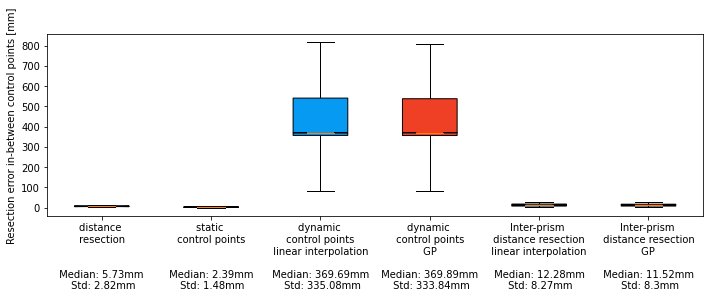

In [79]:
%matplotlib inline

fig = plt.figure(figsize =(10, 4))
ax = fig.add_subplot(111)

box = ax.boxplot([error_all_distance_resection, errors_static_cp, errors_linear_dynamic_cp, errors_gp_dynamic_cp, 
                  errors_linear_inter_prism, errors_gp_inter_prism], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1,2,3,4,5,6], ["distance \n resection \n\n\n Median: "+str(round(np.median(error_all_distance_resection),2))+"mm \n Std: "+str(round(np.std(error_all_distance_resection),2))+"mm", 
                           "static \n control points \n\n\n Median: "+str(round(np.median(errors_static_cp),2))+"mm \n Std: "+str(round(np.std(errors_static_cp),2))+"mm", 
                           "dynamic \n control points \n linear interpolation \n\n Median: "+str(round(np.median(errors_linear_dynamic_cp),2))+"mm \n Std: "+str(round(np.std(errors_linear_dynamic_cp),2))+"mm",
                           "dynamic \n control points \n GP \n\n Median: "+str(round(np.median(errors_gp_dynamic_cp),2))+"mm \n Std: "+str(round(np.std(errors_gp_dynamic_cp),2))+"mm",
                           "Inter-prism \n distance resection \n linear interpolation \n\n Median: "+str(round(np.median(errors_linear_inter_prism),2))+"mm \n Std: "+str(round(np.std(errors_linear_inter_prism),2))+"mm",
                           "Inter-prism \n distance resection \n GP \n\n Median: "+str(round(np.median(errors_gp_inter_prism),2))+"mm \n Std: "+str(round(np.std(errors_gp_inter_prism),2))+"mm"])
colors_box = ['#069AF3', '#EF4026', '#069AF3', '#EF4026', '#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error in-between control points [mm]")
fig.tight_layout()
plt.show()